# All the functions we will use

In [2]:
def auxEdgesCreation(node1, node2, auxEdges):
    '''This auxEdges is a dictionary where the key is the node and the values are a list of its neighbors.
    It receives 2 neighbor nodes and the current auxEdges, returns the auxEdges with the new neighbors added.'''
    if int(node1) not in auxEdges:
        auxEdges[int(node1)] = [int(node2)]
    else:
        auxEdges[int(node1)].append(int(node2))
        
def VPointersActEdgesFromEdges(nodes, auxEdges, Infected):
    '''This function receives the number of nodes and the auxEdges dictionary and returns a
    dictionary with the Pointers and a list containing the ordered neighbor nodes (V).'''
    Pointers={}
    V=[]
    V_active=[]
    ActiveEdges=[]
    for i in range(nodes):
        if i==0: #We started the positioning at 0 for the node 0
            Pointers[i]=[0, (Degree[0]-1)] 
        else: #It recovers the previous final pointer and add the the degree to obtain the actual final pointer
            Pointers[i]=[Pointers[i-1][1]+1, Pointers[i-1][1]+Degree[i]]
            
            #It puts all neighbors on a single list
        for j in sorted(auxEdges[i]):
            V.append(j)
            if i in Infected:
                if j in Infected:
                    V_active.append(0)
                else:
                    ActiveEdges.append([i,j])
                    V_active.append(len(ActiveEdges)) #This will be position think about index=position-1
            else:
                V_active.append(0)
                
    return V, Pointers, V_active, ActiveEdges

def NearestNeighborDegree(Degree,differentK, V, Pointers):
    '''Thius function inputs are the vector Degree, differentK, V and Pointers and returns a dictionary with
    the k and its average nearest neighbor degree'''
    AverageNNDeg={}
    for k in differentK:
        suma=0.
        #This itertes for all the equal k
        for node in np.where(Degree == k)[0]:
            suma2=0.
            # We check the neigbors degree
            for neighbor in range(Pointers[node][0], Pointers[node][1]+1):
                suma2+=float(Degree[V[neighbor]])
            # Here we average the neigbors degree of each node of degree k
            suma+=suma2/float(k)

        # Here we average for all nodes of degree k
        AverageNNDeg[k]=suma/(float(np.count_nonzero(Degree == k))*CorrectionNNDegree)
        
    return AverageNNDeg

def Clusterization(V, Pointers):
    '''This function computes the clusterization per degree k returnad as a dictionary, the inputs are
    the vector of neighbors V and the nodes dictionary Pointers'''
    cluster={} #We initialize the clustering dictionary
    triangles_i=np.zeros(nodes, dtype=int) #Here we will put the triangles per node
    for node in range(nodes):
        neighbor_i = V[Pointers[node][0]:Pointers[node][1]+1] #We look for each node neighbors
        count=0
        for neighbor1 in neighbor_i: #We iterate for each neighbor
            count+=1
            #We check if the neighbor of the neighor is a neigbor of the node too (a trinagle)
            for neighbor2 in neighbor_i[count:]:
                if neighbor1 in V[Pointers[neighbor2][0]:Pointers[neighbor2][1]+1]:
                    triangles_i[node]+=1

    for k in differentK:
        if k > 1: #Of course if we only have a neighbor there is no triangle
            c_i=0
            for node in np.where(Degree == k)[0]: #Here we average the triangles have all nodes with degree k
                c_i+=2.*triangles_i[node]/float(k*(k-1)) #Normalizing for all the possible triplets
            cluster[k]=c_i/float(np.count_nonzero(Degree == k))
    return cluster

#Configuration Model
def stubFunc(nodes, Degree):
    '''This function recieves de number of nodes and the Degree vector which contains the degrees of each node,
    matching its position in the vector with its corresponding node.'''
    stubs=[] #This will be a vector of tails associated to each node, as tails as degree it is. 
    for node in range(nodes):
        for i in range(Degree[node]):
            stubs.append(node) #Here it is filled the vectos with as times the node as tails it has in order to pair them.
    return stubs

def shuffle_and_pair(numb, edges, max_attempts=20):
    '''As it is said this function suffle a list of numbers (numb), it needs the global number of edges (edges)
    and also needs a max_attempts to suffle before we consider it as an infinite bucle.'''
    import random

    attempts = 0 #Set de attemp 0
    numbers=numb.copy() #It is necessary to duplicate the input list of numbers in order to recall this function

    while attempts < max_attempts:
        random.shuffle(numbers) #We suffle them
        pairs = [] #Pairs will be the random edges list.
        auxCMEdges={} #As it is used befores i for the CM_V confection

        i = 0
        while i < len(numbers): #It tries to pair until the stub list is empty
            num1 = numbers[i] #Set the first node

            #It iterates for the following numbers until it founds a pair or until it runs all the list
            j = i + 1 
            while j < len(numbers):
                num2 = numbers[j]
                if num1 < num2: #I want the first node to be the little
                    #The following try finds out if the edge is already in pairs more rapidly than the
                    #[num1,num2] in pairs construction.
                    try:
                        #If it already exists nothing happens
                        pairs.index([num1,num2]) 
                    except:
                        #If it is not, it addes the pair to the pairs list
                        pairs.append([num1, num2]) 
                        auxEdgesCreation(num1, num2, auxCMEdges)
                        auxEdgesCreation(num2, num1, auxCMEdges)
                        #We remove the nodes from the number list in order no to use them again.
                        numbers.remove(num1)
                        numbers.remove(num2)
                        i -= 1
                        break
                j += 1

            #If it runs all the list number and not a match is found it breaks the bucle
            if j == len(numbers):
                break

            i += 1

        if edges == len(pairs): #If the pairs list is equal in length than the edges it retuns it
            return pairs, auxCMEdges

        attempts += 1

    #If the pairs list cannot be completed due to the randomness it starts again in a 20 attempts interval
    return shuffle_and_pair(numb, edges, max_attempts)

########################################################################################################
########################################   SIS epidemic model   ########################################
########################################################################################################

def infected(NInfected,nodes):
    '''It recieves a number of infected nodes and the actual total nodes, it returns a list of nodes infected'''
    Infected=[] #Initialization of infected nodes
    while len(Infected) < NInfected: #We infect nodes until we reach NInfected
        randInfected=int(rd.random()*nodes) #We infected them randomly
        if randInfected not in Infected: #We check it is not already infected.
            Infected.append(randInfected)
    return Infected

def infection(Infected, V_infected, ActiveEdges, Pointers):
    '''This function receives the actual list of infected nodes Infected, list of active edges (Active edge)
    and the position of the active edge in this list (V_infected) and the pointes dictionary. Then we infect
    a node and returns the inputs updated.'''
    index=int(rd.random()*len(ActiveEdges)) #Pic a random Active edge
    node_infected=ActiveEdges[index][1] #We see for the node susceptible selected and hen we infect it.
    Infected.append(node_infected) #It is added to the infected list of nodes. 
    
    for neighbor in V[Pointers[node_infected][0]:Pointers[node_infected][1]+1]: 
        #We run all infected node neighbors to update the other lists
    
        if neighbor in Infected: #We check if the neighbor is infected too
            if ActiveEdges[-1]!=[neighbor,node_infected]: #We check if it is not the last active edge
                
                #We find the index in the ActiveEdges list
                neighborIndex=Pointers[neighbor][0]+V[Pointers[neighbor][0]:Pointers[neighbor][1]+1].index(node_infected)
                replacedEdgeIndex = V_infected[neighborIndex]-1
                
                #We eliminate it by substituting the last active edge by the actual we want to remove 
                eliminatedEdge=ActiveEdges[replacedEdgeIndex]
                #We set its position in the V_infected to 0
                #newIndexNeighbor = Pointers[eliminatedEdge[0]][0]+V[Pointers[eliminatedEdge[0]][0]:Pointers[eliminatedEdge[0]][1]+1].index(node_infected)
                V_infected[neighborIndex]=0

                #We eliminate the last edge becaus it has been relocated
                lastEdge=ActiveEdges.pop()
                ActiveEdges[replacedEdgeIndex]=lastEdge
                
                #We update the last edge position in ActiveEdge list
                newIndexNeighbor = Pointers[lastEdge[0]][0]+V[Pointers[lastEdge[0]][0]:Pointers[lastEdge[0]][1]+1].index(lastEdge[1])
                V_infected[newIndexNeighbor]=replacedEdgeIndex+1
                
            else: #If it is the last ActiveEdge we just eliminated it 
                lastEdge=ActiveEdges.pop()
                
                #We set to 0 the position of the eliminated edge in the vector positions
                newIndexNeighbor = Pointers[lastEdge[0]][0]+V[Pointers[lastEdge[0]][0]:Pointers[lastEdge[0]][1]+1].index(lastEdge[1])
                V_infected[newIndexNeighbor]=0
                
        else:
            #If the neighbor is not infected we just add the new Active Edge
            ActiveEdges.append([node_infected,neighbor])
            #We set the position on the position vectors
            newSuceptibleNode = Pointers[node_infected][0]+V[Pointers[node_infected][0]:Pointers[node_infected][1]+1].index(neighbor)
            V_infected[newSuceptibleNode]=len(ActiveEdges)
    
    return Infected, V_infected, ActiveEdges

def recovery(Infected, V_infected, ActiveEdges, Pointers):
    '''This function receives the actual list of infected nodes Infected, list of active edges (Active edge)
    and the position of the active edge in this list (V_infected) and the pointes dictionary. Then we recover
    a node and returns the inputs updated.'''
    index=int(rd.random()*len(Infected)) #We select the node to recover
    node_recovered=Infected[index]
    
    if node_recovered != Infected[-1]: #We check is not the last node and we switch positions and pop the node recovered
        lastNode = Infected.pop()
        Infected[index]=lastNode
    else: #It is the last node we just pop it
        lastNode = Infected.pop()
    
    #Now we check its neighbors
    for neighbor in V[Pointers[node_recovered][0]:Pointers[node_recovered][1]+1]:
        if neighbor in Infected: #If the neighbor is infected we have to include active edges and its position to the position vector
            ActiveEdges.append([neighbor,node_recovered])
            newIndexNeighbor = Pointers[neighbor][0]+V[Pointers[neighbor][0]:Pointers[neighbor][1]+1].index(node_recovered)
            V_infected[newIndexNeighbor]=len(ActiveEdges)
        else: #If the neighbor is not infected we have to remove the active edges
            if ActiveEdges[-1]!=[node_recovered,neighbor]: #Checking it is not the las edge
                #We find the index
                neighborIndex=Pointers[node_recovered][0]+V[Pointers[node_recovered][0]:Pointers[node_recovered][1]+1].index(neighbor)
                replacedEdgeIndex = V_infected[neighborIndex]-1

                #We eliminate it by substituting the last active edge by the actual we want to remove
                eliminatedEdge=ActiveEdges[replacedEdgeIndex]
                #We set its position in the V_infected to 0
                newIndexNeighbor = Pointers[eliminatedEdge[0]][0]+V[Pointers[eliminatedEdge[0]][0]:Pointers[eliminatedEdge[0]][1]+1].index(eliminatedEdge[1])
                V_infected[newIndexNeighbor]=0

                #We eliminate the last edge becaus it has been relocated
                lastEdge=ActiveEdges.pop()
                ActiveEdges[replacedEdgeIndex]=lastEdge

                #We update the last edge position in ActiveEdge list
                newIndexNeighbor = Pointers[lastEdge[0]][0]+V[Pointers[lastEdge[0]][0]:Pointers[lastEdge[0]][1]+1].index(lastEdge[1])
                V_infected[newIndexNeighbor]=replacedEdgeIndex+1
            else: #If it is the last ActiveEdge we just eliminated it
                lastEdge=ActiveEdges.pop()
                
                #We set to 0 the position of the eliminated edge in the vector positions
                newIndexNeighbor = Pointers[lastEdge[0]][0]+V[Pointers[lastEdge[0]][0]:Pointers[lastEdge[0]][1]+1].index(lastEdge[1])
                V_infected[newIndexNeighbor]=0
    
    return Infected, V_infected, ActiveEdges

def runge_kutta4(system, variables, t, dt,lambd, nodes):
    '''This is the runge kutta4 algorithm to integrate analytically differential equations, it receives the
    ODEs (system), the dependen variable (variables), the independent variable (t), the itegration step (dt),
    the lambda rate (lambd) and the number of nodes (nodes) and it returns the updated value of variables 
    (variables_new) for a single step'''
    k1 = system(variables, t,lambd, nodes)
    k2 = system(variables + 0.5*dt*k1, t + 0.5*dt,lambd, nodes)
    k3 = system(variables + 0.5*dt*k2, t + 0.5*dt,lambd, nodes)
    k4 = system(variables + dt*k3, t + dt,lambd, nodes)
    variables_new = variables + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    
    return variables_new

def system(y,t,lambd,nodes):
    '''This is the differential equations system, receives the the dependen variable (y), the independent
    variable (t), the lambda parameter (lambd) and the number of nodes (nodes) and it returns the dependent
    variable increment (dy)'''
    dy=np.zeros(nodes)
    for node in range(nodes):
        suma=0
        for neighbor in V[Pointers[node][0]:Pointers[node][1]+1]:
            suma+=y[neighbor]*(1-y[node])
        dy[node]=-y[node]+lambd*suma
    return dy

# ASSIGNMENT 1

In [3]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import time
import csv
import pandas as pd
from scipy.integrate import odeint

inicio=time.time()

nodes=3892 #Network nodes
NEdges=17239 #Network edges, this network doesn't repeat the edges, I mean if [node1,node2] then [node2,node1] doesn't exist 

edges = [] #Edges list is initialized
Degree=np.zeros(nodes, dtype=int) #Degree array is initialized
Pointers={} #Pointers dictionary is initialized
auxEdges = {} #auxEdges dictionary is initialized

#Initial conditions for the SIS epidemic model
Infected0 = 15 #Number of infected nodes at t=0
Infected = infected(Infected0,nodes) #Vector of infected nodes
rho_t0 = Infected0/nodes #Initial infected rate

with open('./fb-pages-tvshow/edges.csv', 'r') as file: #It is read the edgelist
    for line in file:
        n1, n2 = line.strip().split(',') # Assumes nodes are separated by a comme
        n1, n2 = int(n1), int(n2)
        if n1!='source':
            if n2!=n1: #It cancel the selfloops
                edges.append([n1, n2]) #It appends the edge to memmory
                Degree[n1]+=1 #If finds a node it adds a unit to its degree
                Degree[n2]+=1 #If finds a node it adds a unit to its degree for the right column
                auxEdgesCreation(n1, n2, auxEdges)
                auxEdgesCreation(n2, n1, auxEdges)

V, Pointers, V_infected, ActiveEdges=VPointersActEdgesFromEdges(nodes, auxEdges, Infected) # V and Pointers confection

#This writes the degrees of each node
with open('./degrees.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["#Node", "Degree"])
    for node in range(nodes):
        writer.writerow([node, Degree[node]])


In [6]:
#It is computed the momentums of order 1 and 2 dor the degree
DegreeMom1 = 0
DegreeMom2 = 0
for i in Degree:
    DegreeMom1+=i
    DegreeMom2+=i*i
DegreeMom1=DegreeMom1/len(Degree)
DegreeMom2=DegreeMom2/len(Degree)
CorrectionNNDegree=DegreeMom2/DegreeMom1 #This is the corection factor for the Knn
CriticalLambda = 1/CorrectionNNDegree #This is the value of lambda in the SIS model which separates the two behaviors
print('The average degree is:', DegreeMom1)
print('Check number of nodes and links, <k>*nodes:', int(DegreeMom1*nodes),"must be equal to 2*E", 2*len(edges))
print('Degree variance', DegreeMom2-DegreeMom1*DegreeMom1)
print('Critical lambda = ',CriticalLambda)

#The structural and real cut off cheking
print('K_max structural is: ', np.sqrt(DegreeMom1*nodes),'K_max real is: ', max(Degree))

The average degree is: 8.85868448098664
Check number of nodes and links, <k>*nodes: 34478 must be equal to 2*E 34478
Degree variance 157.6938017637571
Critical lambda =  0.03750976420133729
K_max structural is:  185.6825247566394 K_max real is:  126


In [5]:
1/CorrectionNNDegree

0.03750976420133729

# ASSIGNMENT 2

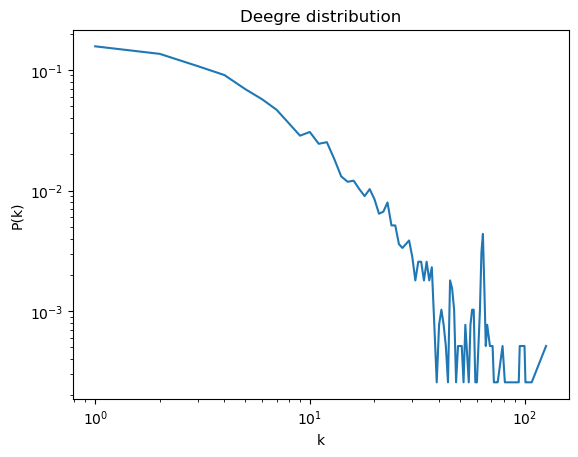

In [34]:
degreeDensity = {} #We initialize a dictionary which we will use to plot the degree distribution
disorderedDensity={} #We initialize another dictionary which we will use order the keys ascendently

#We count degrees as we found them
for degree in Degree:
    if degree in disorderedDensity:
        disorderedDensity[degree] += 1.
    else:
        disorderedDensity[degree] = 1.
        
#Here we order and normalize
for valor in sorted(disorderedDensity):
    degreeDensity[valor] = disorderedDensity[valor]/sum(disorderedDensity.values())

#This is an auxiliary list to know the k we have at least one time
differentK=list(degreeDensity)

plt.plot(degreeDensity.keys(), degreeDensity.values(), '-')

plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('Deegre distribution')

plt.xscale('log')
plt.yscale('log')

plt.savefig('P(k)_degree_distr')


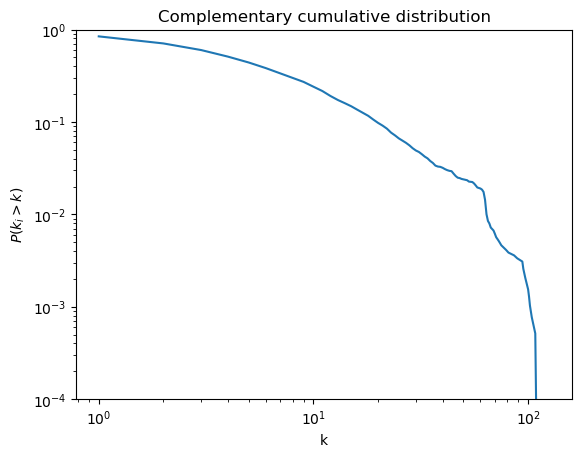

In [35]:
complcumulativeDegDistr={} #We initialize a dictionary to compute the complementary cumulative degree distribution

#We run the different k
for k in differentK:
    if k == 1:
        # We compute the first value
        complcumulativeDegDistr[k]=1-degreeDensity[k]
    else:
        # We substrac each contribution the the cumulative degree distribution
        complcumulativeDegDistr[k]=complcumulativeDegDistr[differentK[differentK.index(k)-1]]-degreeDensity[k]

plt.plot(complcumulativeDegDistr.keys(), complcumulativeDegDistr.values(),'-')
plt.xlabel('k') 
plt.ylabel('$P(k_i > k)$')
plt.title('Complementary cumulative distribution')

plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-4,10**0])

plt.savefig('Compl_cumulative_distr')

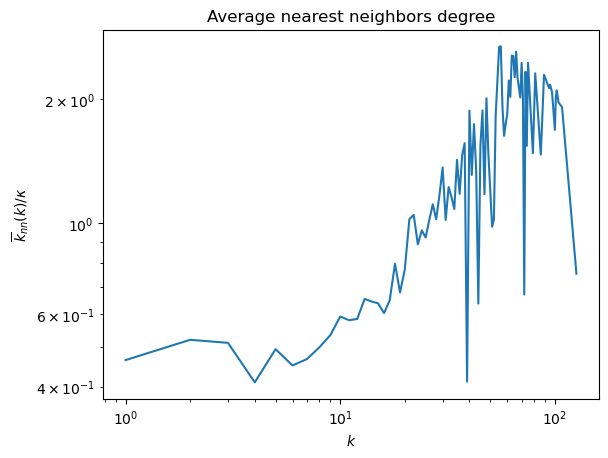

In [36]:
#We compute the nearest neighbor degree dictionary
AverageNNDeg=NearestNeighborDegree(Degree,differentK, V, Pointers)
    
plt.plot(list(AverageNNDeg.keys()), list(AverageNNDeg.values()), '-', label = "Real NW")
plt.xlabel('$k$') 
plt.ylabel('$ \overline{k}_{nn}(k)/\kappa$')
plt.title('Average nearest neighbors degree')

plt.xscale('log')
plt.yscale('log')

plt.savefig('Knn(k)_real')


Average real clustering: 0.5478674537705505


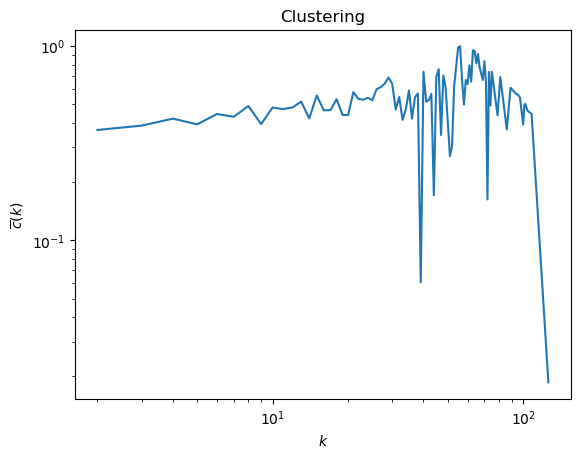

In [37]:
#Clusterization for the real network
cluster=Clusterization(V, Pointers)
              
plt.plot(list(cluster.keys()), list(cluster.values()), '-', label = "Real NW")

plt.xlabel('$k$') 
plt.ylabel('$ \overline{c}(k)$')
plt.title('Clustering')

plt.xscale('log')
plt.yscale('log')

plt.savefig('Clustering_real')

#Here we compute the average clusterization parameter
Av_cluster=0
for value in cluster:
    Av_cluster+=cluster[value]/float(len(cluster))
    
print('Average real clustering:', Av_cluster)


# Assigment 5

In [ ]:
CM_realizations=100 #This gives the number of Configurational Models we will create
CMEdges=[] #CM Edges list of lists is initialized
auxCMEdges=[] #CM auxEdges list of dicts is initialized
CM_V=[] #CM V list of lists is initialized
CM_Pointers=[] #CM Pionters list of dicts is initialized

#We make 100 CM form the original network, and we sotre the vectos V and pointers of each realization
for k in range(CM_realizations):
    print('It is the realization #', k)
    aux1, aux2=shuffle_and_pair(stubFunc(nodes, Degree), NEdges)
    CMEdges.append(aux1)
    auxCMEdges.append(aux2)

    aux3, aux4=VPointersFromEdges(nodes, auxCMEdges[k])
    CM_V.append(aux3)
    CM_Pointers.append(aux4)

In [ ]:
#We compute the nearest neighbor degree dictionary
AverageNNDeg=NearestNeighborDegree(Degree,differentK, V, Pointers)

#It is computed the neares neighbor degree for aech CM
average_CM_NNDeg={}
for CM_i in range(CM_realizations):
    CMAverageNNDeg=NearestNeighborDegree(Degree,differentK,CM_V[CM_i],CM_Pointers[CM_i])
    #Here we add the contributions of each CM for each k
    for k in differentK:
        average_CM_NNDeg[k]=CMAverageNNDeg[k]/CM_realizations
    
plt.plot(list(AverageNNDeg.keys()), list(AverageNNDeg.values()), '-', label = "Real NW")
plt.plot(list(average_CM_NNDeg.keys()), list(average_CM_NNDeg.values()), 'r-', label = "CM NW")
plt.legend(loc = 6)
plt.xlabel('$k$') 
plt.ylabel('$ \overline{k}_{nn}(k)/\kappa$')
plt.title('Average nearest neighbors degree')

plt.xscale('log')
plt.yscale('log')

plt.savefig('Knn(k)_CM')

In [ ]:
#We average for the 100 CM cluster
average_CM_cluster={} #Initialization for the average CM cluster

#It is computed the clusterization for each CM
for CM_i in range(CM_realizations):
    CMCluster=Clusterization(CM_V[CM_i],CM_Pointers[CM_i])
    #Here we add the contributions of each CM for each k
    for k in differentK:
        if k > 1:
            average_CM_cluster[k]=CMCluster[k]/CM_realizations
    
#Clusterization for the real network
cluster=Clusterization(V, Pointers)
              
plt.plot(list(cluster.keys()), list(cluster.values()), '-', label = "Real NW")

plt.plot(list(average_CM_cluster.keys()), list(average_CM_cluster.values()), 'r-', label="CM NW") 

plt.legend(loc = 6)
plt.xlabel('$k$') 
plt.ylabel('$ \overline{c}(k)$')
plt.title('Clustering')

plt.xscale('log')
plt.yscale('log')

plt.savefig('Clustering_CM')

#Here we compute the average clusterization parameter
Av_CM_cluster=0
for value in average_CM_cluster:
    Av_CM_cluster+=average_CM_cluster[value]/float(len(average_CM_cluster))
    
print('Average CM clustering:', Av_CM_cluster)

# SIS epidemic model

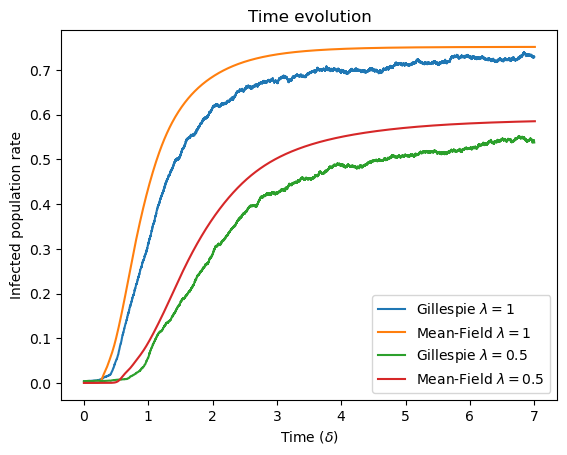

In [13]:
lambd=1. #Random lambda to show the time evolution

tfin=7. #Time when the system is at the stationary regime
#Integration of ODEs with the Runge Kutta 4

# Ejemplo de uso
t0 = 0.0  # Tiempo inicial
rho0 = np.zeros(nodes)

for node in Infected:
    rho0[node]+=1/nodes

dt = 0.01  #Time step

rhos_i=[]
times=[]
# Resolución del sistema utilizando Runge-Kutta 4
t = t0
rho = rho0
rhos_i.append(rho.mean())
times.append(t)
while t < tfin:
    rho = runge_kutta4(system, rho, t, dt,lambd, nodes)
    t += dt
    rhos_i.append(rho.mean())
    times.append(t)


#We initialize the Gillespie algorithm 
t=t0
vect_t=[t]
vect_rho=[rho_t0]

#We save this vectors
Infected1=Infected.copy()
V_infected1=V_infected.copy()
ActiveEdges1=ActiveEdges.copy()

while t < tfin: #We repeat the algorithm until we reach the stationary regime
    #We compute the rate 
    PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1)) 
    if PoissonLambda>0.001:
        #We compute the processes rates
        P_recover = float(len(Infected1))/PoissonLambda

        randProcess = rd.random()

        #We choose which process we activate
        if randProcess < P_recover:
            #Recover process
            Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
        else:
            #Infection process
            Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 

        tau=np.random.exponential(1 / PoissonLambda) #We add increment time generated with a Poisson distribution
    else:
        tau=0.1
    t+=tau
    vect_t.append(t)
    vect_rho.append(float(len(Infected1))/float(nodes))

#############################################################################################################
#We try another lambda
lambd=0.5

rhos_i2=[]
times2=[]
# Resolución del sistema utilizando Runge-Kutta 4
t = t0
rho2 = rho0
rhos_i2.append(rho2.mean())
times2.append(t)
while t < tfin:
    rho2 = runge_kutta4(system, rho2, t, dt,lambd, nodes)
    t += dt
    rhos_i2.append(rho2.mean())
    times2.append(t)
    
t=t0
vect_t2=[t]
vect_rho2=[rho_t0]

#We save this vectors
Infected1=Infected.copy()
V_infected1=V_infected.copy()
ActiveEdges1=ActiveEdges.copy()

while t < tfin: #We repeat the algorithm until we reach the stationary regime
    #We compute the rate 
    PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1)) 
    if PoissonLambda>0.001:
        #We compute the processes rates
        P_recover = float(len(Infected1))/PoissonLambda

        randProcess = rd.random()

        #We choose which process we activate
        if randProcess < P_recover:
            #Recover process
            Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
        else:
            #Infection process
            Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 

        tau2=np.random.exponential(1 / PoissonLambda) #We add increment time generated with a Poisson distribution
    else:
        tau2=0.1
    t+=tau2
    vect_t2.append(t)
    vect_rho2.append(float(len(Infected1))/float(nodes))
    
plt.plot(vect_t, vect_rho, '-', label = "Gillespie $\lambda=1$")
plt.plot(times, rhos_i,'-',label = "Mean-Field $\lambda=1$")
plt.plot(vect_t2, vect_rho2, '-', label = "Gillespie $\lambda=0.5$")
plt.plot(times2, rhos_i2,'-',label = "Mean-Field $\lambda=0.5$")

plt.xlabel('Time ($\delta$)')
plt.ylabel('Infected population rate')
plt.title('Time evolution')
plt.legend()

plt.show()

/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:16: RuntimeWarning: overflow encountered in double_scalars
  suma+=y[neighbor]*(1-y[node])
/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:16: RuntimeWarning: invalid value encountered in double_scalars
  suma+=y[neighbor]*(1-y[node])
/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:17: RuntimeWarning: invalid value encountered in double_scalars
  dy[node]=-y[node]+lambd*suma
/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dy[node]=-y[node]+lambd*suma
/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:7: RuntimeWarning: invalid value encountered in add
  variables_new = variables + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
/var/folders/vn/4d7qybf97nl5z3_6cyjgcbyr0000gn/T/ipykernel_82248/2269522423.py:7: RuntimeWarning: overflow encountered

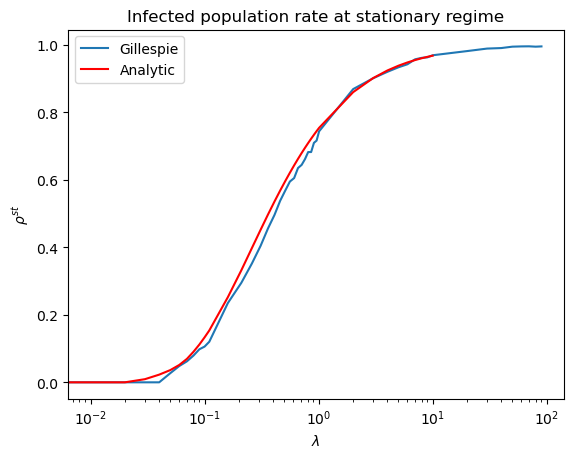

282.8077309012413


In [41]:
ini=time.time()
#Stationary infected rato vs lambda value
#Restart the time
t=0.
#We choose different times to reach the stationary value in order to reduce the time simulations
tfin1=15.
tfin2=7.
tfin3=1.5

#We initialice the vectors
rho_stat=[]
rho_stat_an=[]
lambdas=[]

lambd=0.01 #We start with this lambda
lambda_max=100 #Lambda max

#Initialize for the meann field
rho0 = np.zeros(nodes)
for node in Infected:
    rho0[node]+=1/nodes

#Initial step
rho_stat.append(0.0)
rho_stat_an.append(0.0)
lambdas.append(0.0)

#tfin for the firsts lambdas
tfin=tfin1
while lambd < lambda_max: #We repeat the simulations until we run all lambdas
    t0=0
    
    
    #Runge kutta 4
    # Resolución del sistema utilizando Runge-Kutta 4
    t_an = t0
    rho=rho0.copy()
    while t_an < tfin:
        rho = runge_kutta4(system, rho, t_an, dt,lambd, nodes)
        t_an += dt

    rho_stat_an.append(rho.mean())

    Infected1=Infected.copy()
    V_infected1=V_infected.copy()
    ActiveEdges1=ActiveEdges.copy()

    t=t0
    #Gillespie algorithm
    while t < tfin:
        PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1))
        if PoissonLambda>0.001:
            P_recover = float(len(Infected1))/PoissonLambda

            randProcess = rd.random()

            if randProcess < P_recover:
                Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
            else:
                Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 

            tau=np.random.exponential(1 / PoissonLambda)
        else:
            tau=0.1
        t+=tau
    
    lambdas.append(lambd)
    rho_stat.append(float(len(Infected1))/float(nodes))
    
    #We change the lambda steps and time depending on lambda value
    if lambd<0.1:
        lambd+=0.01
        
    elif lambd<1:
        lambd+=0.05
        
    elif lambd<10:
        lambd+=1
        tfin=tfin2
        
    else:
        lambd+=10
        tfin=tfin3

plt.plot(lambdas, rho_stat, '-', label = "Gillespie")
plt.plot(lambdas,rho_stat_an,'r-', label = "Mean-Field")

plt.xlabel('$\lambda$')
plt.ylabel('$ρ^{st}$')
plt.title('Infected population rate at stationary regime')
plt.xscale('log')
plt.legend()

plt.show()

print((time.time()-ini)/60)

# What happens if we change the $\lambda$ value once we reach the first steady state for $\lambda$ = 40

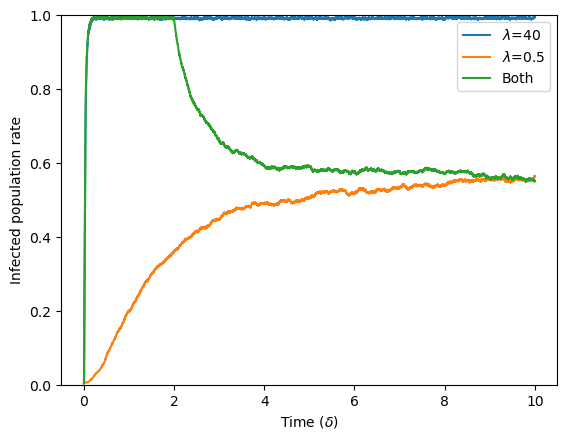

In [31]:
lambda1=40 #We reach the stationary value
lambda2=0.5 #Then we change lambda simulating a infection reduction

tfin=10.
tchange=2. #This will be the time we will change the lambda


#############################################################################################################
#Gillespie for the lambda = 40
Infected1=Infected.copy()
V_infected1=V_infected.copy()
ActiveEdges1=ActiveEdges.copy()

t=0.
vect_t1=[t]
vect_rho1=[rho_t0]
lambd=lambda1
while t < tfin:
    PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1))
    if PoissonLambda>0.001:
        P_recover = float(len(Infected1))/PoissonLambda
        randProcess = rd.random()
        if randProcess < P_recover:
            Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
        else:
            Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 
        tau=np.random.exponential(1 / PoissonLambda)
    else:
        tau=0.1
    t+=tau
    vect_t1.append(t)
    vect_rho1.append(float(len(Infected1))/float(nodes))
    
#############################################################################################################
#Gillespie for the lambda = 0.5
Infected1=Infected.copy()
V_infected1=V_infected.copy()
ActiveEdges1=ActiveEdges.copy()

t=0.
vect_t2=[t]
vect_rho2=[rho_t0]
lambd=lambda2
while t < tfin:
    PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1))
    if PoissonLambda>0.001:
        P_recover = float(len(Infected1))/PoissonLambda
        randProcess = rd.random()
        if randProcess < P_recover:
            Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
        else:
            Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 
        tau=np.random.exponential(1 / PoissonLambda)
    else:
        tau=0.1
    t+=tau
    vect_t2.append(t)
    vect_rho2.append(float(len(Infected1))/float(nodes))
    
#############################################################################################################
#Gillespie for the changing lambda
Infected1=Infected.copy()
V_infected1=V_infected.copy()
ActiveEdges1=ActiveEdges.copy()

t=0.
vect_t3=[t]
vect_rho3=[rho_t0]
lambd=lambda1
while t < tfin:
    PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1))
    if PoissonLambda>0.001:
        P_recover = float(len(Infected1))/PoissonLambda
        randProcess = rd.random()
        if randProcess < P_recover:
            Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
        else:
            Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 
        tau=np.random.exponential(1 / PoissonLambda)
    else:
        tau=0.1
    t+=tau
    vect_t3.append(t)
    vect_rho3.append(float(len(Infected1))/float(nodes))
    if t>tchange: #Here we change the lambda
        lambd=lambda2
    
plt.plot(vect_t1, vect_rho1, '-', label = "$\lambda$=40")
plt.plot(vect_t2, vect_rho2, '-', label = "$\lambda$=0.5")
plt.plot(vect_t3, vect_rho3, '-', label = "Both")

plt.xlabel('Time ($\delta$)')
plt.ylabel('Infected population rate')
plt.legend()
plt.ylim(0,1)

plt.show()

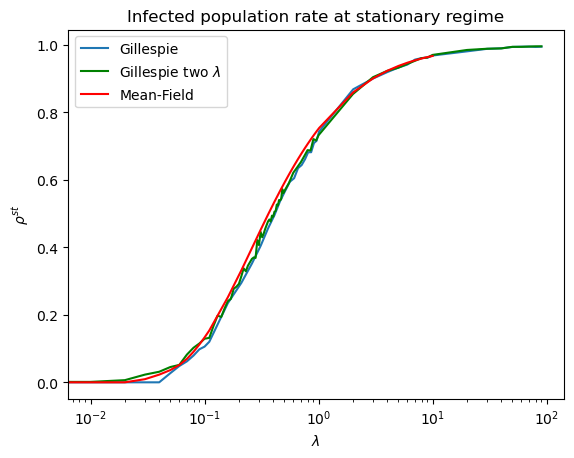

In [44]:
lambda1=100 #Initial lambda for each simulation
lambda2=0.01 #Lambda from we start

#Time when simulation stops
tfin=10.
#Time when lambda changes
tchange=2.

rho_stat1=[]
lambdas1=[]

rho_stat1.append(0.0)
lambdas1.append(0.0)

while lambda2 < lambda1: #We repeat until we reach the final lambda
#############################################################################################################
    Infected1=Infected.copy()
    V_infected1=V_infected.copy()
    ActiveEdges1=ActiveEdges.copy()

    t=0.
    lambd=lambda1
    
    while t < tfin:
        PoissonLambda=float(len(Infected1))+lambd*float(len(ActiveEdges1))
        if PoissonLambda>0.001:
            P_recover = float(len(Infected1))/PoissonLambda
            randProcess = rd.random()
            if randProcess < P_recover:
                Infected1, V_infected1, ActiveEdges1 = recovery(Infected1, V_infected1, ActiveEdges1, Pointers)
            else:
                Infected1, V_infected1, ActiveEdges1 = infection(Infected1, V_infected1, ActiveEdges1, Pointers) 
            tau=np.random.exponential(1 / PoissonLambda)
        else:
            tau=0.1
        t+=tau
        if t>tchange:
            lambd=lambda2
            
    if lambda2<0.5:
        lambda2+=0.01
        
    elif lambda2<1:
        lambda2+=0.05
        
    elif lambda2<10:
        lambda2+=1
        
    else:
        lambda2+=10
        
    lambdas1.append(lambd)
    rho_stat1.append(float(len(Infected1))/float(nodes))
        
plt.plot(lambdas, rho_stat, '-', label = "Gillespie")
plt.plot(lambdas1, rho_stat1, 'g-', label = "Gillespie two $\lambda$")
plt.plot(lambdas,rho_stat_an,'r-', label = "Mean-Field")

plt.xlabel('$\lambda$')
plt.ylabel('$ρ^{st}$')
plt.title('Infected population rate at stationary regime')
plt.xscale('log')
plt.legend()

plt.show()